# Armado del Dataset

## Instalación de paquetes y datos

In [0]:
!pip install opencv-python

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from numpy.linalg import inv
from glob import glob

%matplotlib inline

In [0]:
def plot_image(img):
    plt.axis('off')
    if len(img.shape) == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')

In [0]:
#!wget -q http://images.cocodataset.org/zips/val2017.zip
#!unzip val2017.zip -d images

!wget -q https://github.com/mez/deep_homography_estimation/archive/master.zip -O mez_code.zip
!unzip -q mez_code.zip
!mv deep_homography_estimation-master/ms_coco_test_images .
!rm -rf deep_homography_estimation-master

In [0]:
test_images = glob(os.path.join('ms_coco_test_images', '*.jpg'))

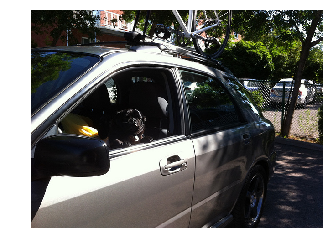

In [0]:
img = plt.imread(test_images[3])
plot_image(img)

## Preparación de la imagen

En primer lugar, preparamos la imagen para el modelo:

1. Reescalamos a $320 \times 240$
2. Convertimos a escala de grises

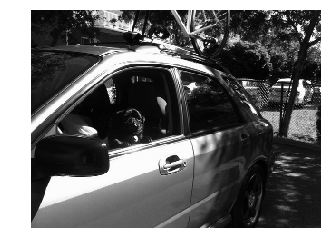

In [0]:
resized_img = cv2.resize(img, (320, 240))
gray_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)
plot_image(gray_img)

## Ubicación del parche P

Tenemos que definir ahora la ubicación del parche $P$ en la imagen. Tal como dice el paper, se busca un punto lejos de los bordes para evitar problemas a la hora de perturbar las esquinas del parche.

Usamos los parámetros:
* $\rho = 32$
* Tamaño del parche = $128 \times 128$

In [0]:
rho = 32
patch_size = 128

In [0]:
height, width = gray_img.shape

# Genera una ubicación aleatoria (desde la esquina de P)
px = random.randint(rho, width - patch_size - rho)
py = random.randint(rho, height - patch_size - rho)

# Anota imagen para visualizar parche P
patch = [(px, py), (px, py+patch_size), (px+patch_size, py+patch_size), (px+patch_size, py)]

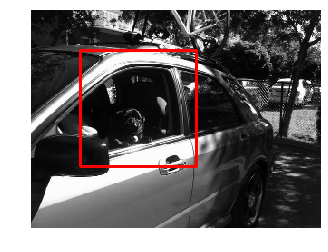

In [0]:
def annotate_with_patch(img, patch):
  img = img.copy()
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  cv2.polylines(img, np.int32([patch]), 1, (255, 0, 0), thickness=2)
  return img

plot_image(annotate_with_patch(gray_img, patch))

## Perturbación de las esquinas de P

Ahora definimos un parche con cada esquina modificada a lo sumo $\rho$ pixeles.

In [0]:
def random_delta(rho):
  return np.random.randint(-rho, rho, size=2)

In [0]:
perturbed_patch = [p + random_delta(rho) for p in patch]

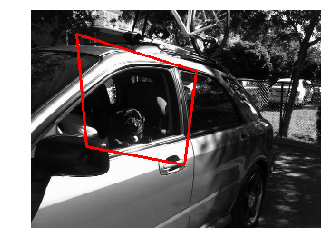

In [0]:
plot_image(annotate_with_patch(gray_img, perturbed_patch))

## Generamos la homografía

Ahora que tenemos los 8 puntos, generamos la matríz de homografía $H$ con la función de opencv `getPerspectiveTransform`, que aplica DLT.

In [0]:
H = cv2.getPerspectiveTransform(np.float32(patch), np.float32(perturbed_patch))
H

array([[ 1.47449146e+00,  2.36057654e-01, -3.12444161e+01],
       [ 4.73084803e-01,  1.47066994e+00, -5.96984336e+01],
       [ 1.44214483e-03,  2.21403107e-03,  1.00000000e+00]])

## Aplicamos la homografía

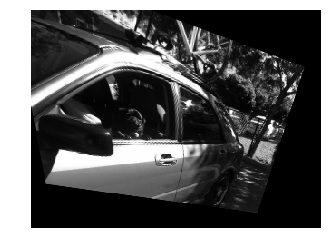

In [0]:
warped_img = cv2.warpPerspective(gray_img, H, (gray_img.shape[1], gray_img.shape[0]))
plot_image(warped_img)

## Ubicamos el parche en la nueva imagen

Ahora ubicamos el parche original (sin perturbaciones) sobre la imagen nueva.

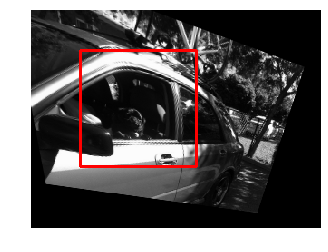

In [0]:
plot_image(annotate_with_patch(warped_img, patch))

## Recolectamos datos para instancias y etiquetas

Finalmente, realizamos los siguientes pasos:

1. Extraemos el parche en la imagen original, y el parche en la imagen reproyectada,
2. Reescalamos las dos imágenes a $128 \times 128$
3. Apilamos las dos imágenes reescaladas en una sola imagen de 2 canales.

La instancia enttonces sería un arreglo multidimensional de tamaño $128 \times 128 \times 2$.

Las etiquetas (al menos para el modelo de regresión), serían los puntos del parche original y los del parche modificado.

In [0]:
def extract_from_patch(img, patch):
  a, _, c, _ = patch
  return img[a[1]:c[1], a[0]:c[0]]

In [0]:
a_img = extract_from_patch(gray_img, patch)
b_img = extract_from_patch(warped_img, patch)

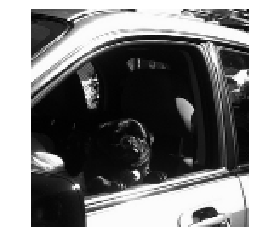

In [0]:
plot_image(a_img)

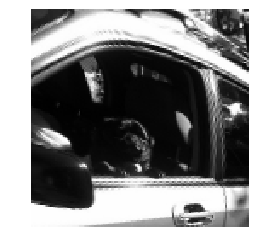

In [0]:
plot_image(b_img)

In [0]:
sample = np.dstack([a_img, b_img])
sample.shape

(128, 128, 2)

In [0]:
label = np.array([perturbed_patch]).ravel()
label.shape

(8,)